In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm


from src.data import load_batch, get_moments, normalize, load_all_train_data
from src.model import Network
from src.utils import sigmoid, multiple_cross_entropy

np.random.seed(42)

In [2]:
# ---------- get data ----------
X, Y, y = load_all_train_data()

N = X.shape[1]
val_indices = np.random.choice(N, size=1000, replace=False)
train_mask = np.ones(N, dtype=bool)
train_mask[val_indices] = False

X_train, X_val = X[:, train_mask], X[:, val_indices]
Y_train, Y_val = Y[:, train_mask], Y[:, val_indices]
y_train, y_val = y[train_mask], y[val_indices]

X_test, Y_test, y_test = load_batch("datasets/cifar-10-batches-py/test_batch")

mean_X, std_X = get_moments(X_train)
X_train = normalize(X_train, mean_X, std_X)
X_val = normalize(X_val, mean_X, std_X)
X_test = normalize(X_test, mean_X, std_X)

In [3]:
# Use smaller subset for grid search
X_train_sub = X_train[:, :5000]
Y_train_sub = Y_train[:, :5000]

In [4]:
# ---------- grid search ----------
lams = [0.001, 0.01, 0.1]
lrs = [0.001, 0.01, 0.1]
ns_batch = [4, 8, 16]
decays_steps = [3, 5, 10]
accs = []
best_val_loss = float('inf')
best_config = None
val_losses = np.zeros((len(lams), len(lrs), len(ns_batch), len(decays_steps)))


epochs = 40  # Define epochs for the training
total_configs = len(lams) * len(lrs) * len(ns_batch) * len(decays_steps)
pbar = tqdm(total=total_configs, desc="Grid search progress")

for i, lam in enumerate(lams):
    for j, lr in enumerate(lrs):
        for k, n_batch in enumerate(ns_batch):
            for z, decays_step in enumerate(decays_steps):
                pbar.set_description(f"Grid search | lam={lam:.0e}, lr={lr:.4f}, batch_size={n_batch}, decay_steps={decays_step}")
                model = Network([X_train.shape[0], Y_train.shape[0]])
                losses = model.train(X_train_sub, Y_train_sub, X_val, Y_val, lam=lam, lr=lr, n_batch=n_batch, decay_steps=decays_step, augmentation=True)
                
                # Track the best configuration
                final_val_loss = losses["val"][max(losses["val"].keys())]
                val_losses[i, j, k, z] = final_val_loss
                
                # Update progress bar
                pbar.update(1)
                
pbar.close()

Grid search progress:   0%|          | 0/81 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [4]:
# Create a list of all configurations and their validation losses
soft_configs = []
for i, lam in enumerate(lams):
    for j, lr in enumerate(lrs):
        for k, n_batch in enumerate(ns_batch):
            for z, decays_step in enumerate(decays_steps):
                soft_configs.append({
                    'lambda': lam,
                    'learning_rate': lr,
                    'batch_size': n_batch,
                    'decay_steps': decays_step,
                    'val_loss': val_losses[i, j, k, z]
                })

# Sort configurations by validation loss in descending order
sorted_configs = sorted(soft_configs, key=lambda x: x['val_loss'], reverse=True)

# Print LaTeX table
print(r"\begin{table}[h]")
print(r"\centering")
print(r"\begin{tabular}{|c|c|c|c|c|c|}")
print(r"\hline")
print(r"Rank & val_loss & $\lambda$ & $\eta$ & Batch Size & Decay Steps \\")
print(r"\hline")
for i, config in enumerate(sorted_configs[:10]):
    print(f"{i+1} & {config['val_loss']:.4f} & {config['lambda']:.1e} & {config['learning_rate']:.1e} & {config['batch_size']} & {config['decay_steps']} \\\\")
    print(r"\hline")
print(r"\end{tabular}")
print(r"\caption{Top 10 configurations ranked by validation loss}")
print(r"\label{tab:top_configs}")
print(r"\end{table}")

\begin{table}[h]
\centering
\begin{tabular}{|c|c|c|c|c|c|}
\hline
Rank & Accuracy & $\lambda$ & $\eta$ & Batch Size & Decay Steps \\
\hline
1 & 0.4221 & 1.0e-02 & 1.0e-02 & 16 & 3 \\
\hline
2 & 0.4206 & 1.0e-02 & 1.0e-01 & 8 & 3 \\
\hline
3 & 0.4202 & 1.0e-02 & 1.0e-01 & 4 & 5 \\
\hline
4 & 0.4201 & 1.0e-02 & 1.0e-03 & 8 & 5 \\
\hline
5 & 0.4201 & 1.0e-02 & 1.0e-01 & 8 & 5 \\
\hline
6 & 0.4191 & 1.0e-02 & 1.0e-01 & 16 & 5 \\
\hline
7 & 0.4190 & 1.0e-03 & 1.0e-03 & 8 & 5 \\
\hline
8 & 0.4184 & 1.0e-02 & 1.0e-03 & 4 & 5 \\
\hline
9 & 0.4182 & 1.0e-02 & 1.0e-03 & 4 & 3 \\
\hline
10 & 0.4181 & 1.0e-02 & 1.0e-02 & 4 & 3 \\
\hline
\end{tabular}
\caption{Top 10 configurations ranked by accuracy}
\label{tab:top_configs}
\end{table}


In [ ]:


# ---------- grid search ----------
lams = [0.001, 0.01, 0.1]
lrs = [0.001, 0.01, 0.1]
ns_batch = [4, 8, 16]
decays_steps = [3, 5, 10]
accs = []
all_losses = {}
best_val_loss = float('inf')
best_config = None

# Store results in a structured way for the heatmap
accuracy_results = np.zeros((len(lams), len(lrs), len(ns_batch), len(decays_steps)))

for i, lam in enumerate(lams):
    for j, lr in enumerate(lrs):
        for k, n_batch in enumerate(ns_batch):
            for z, decays_step in enumerate(decays_steps):
                model = Network([X_train.shape[0], Y_train.shape[0]], sigmoid, multiple_cross_entropy)
                losses = model.train(X_train, Y_train, X_val, Y_val, lam=lam, lr=lr, n_batch=n_batch, decay_steps=decays_step, augmentation=True)
                                
                # Track the best configuration
                final_val_loss = losses["val"][max(losses["val"].keys())]
                val_losses[i, j, k, z] = final_val_loss



Training | lam=1e-03, lr=0.0010, batch_size=4, decay_steps=3:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-03, lr=0.0010, batch_size=4, decay_steps=5:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-03, lr=0.0010, batch_size=4, decay_steps=10:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-03, lr=0.0010, batch_size=8, decay_steps=3:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-03, lr=0.0010, batch_size=8, decay_steps=5:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-03, lr=0.0010, batch_size=8, decay_steps=10:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-03, lr=0.0010, batch_size=16, decay_steps=3:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-03, lr=0.0010, batch_size=16, decay_steps=5:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-03, lr=0.0010, batch_size=16, decay_steps=10:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-03, lr=0.0100, batch_size=4, decay_steps=3:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-03, lr=0.0100, batch_size=4, decay_steps=5:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-03, lr=0.0100, batch_size=4, decay_steps=10:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-03, lr=0.0100, batch_size=8, decay_steps=3:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-03, lr=0.0100, batch_size=8, decay_steps=5:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-03, lr=0.0100, batch_size=8, decay_steps=10:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-03, lr=0.0100, batch_size=16, decay_steps=3:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-03, lr=0.0100, batch_size=16, decay_steps=5:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-03, lr=0.0100, batch_size=16, decay_steps=10:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-03, lr=0.1000, batch_size=4, decay_steps=3:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-03, lr=0.1000, batch_size=4, decay_steps=5:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-03, lr=0.1000, batch_size=4, decay_steps=10:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-03, lr=0.1000, batch_size=8, decay_steps=3:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-03, lr=0.1000, batch_size=8, decay_steps=5:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-03, lr=0.1000, batch_size=8, decay_steps=10:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-03, lr=0.1000, batch_size=16, decay_steps=3:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-03, lr=0.1000, batch_size=16, decay_steps=5:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-03, lr=0.1000, batch_size=16, decay_steps=10:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-02, lr=0.0010, batch_size=4, decay_steps=3:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-02, lr=0.0010, batch_size=4, decay_steps=5:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-02, lr=0.0010, batch_size=4, decay_steps=10:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-02, lr=0.0010, batch_size=8, decay_steps=3:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-02, lr=0.0010, batch_size=8, decay_steps=5:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-02, lr=0.0010, batch_size=8, decay_steps=10:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-02, lr=0.0010, batch_size=16, decay_steps=3:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-02, lr=0.0010, batch_size=16, decay_steps=5:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-02, lr=0.0010, batch_size=16, decay_steps=10:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-02, lr=0.0100, batch_size=4, decay_steps=3:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-02, lr=0.0100, batch_size=4, decay_steps=5:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-02, lr=0.0100, batch_size=4, decay_steps=10:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-02, lr=0.0100, batch_size=8, decay_steps=3:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-02, lr=0.0100, batch_size=8, decay_steps=5:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-02, lr=0.0100, batch_size=8, decay_steps=10:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-02, lr=0.0100, batch_size=16, decay_steps=3:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-02, lr=0.0100, batch_size=16, decay_steps=5:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-02, lr=0.0100, batch_size=16, decay_steps=10:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-02, lr=0.1000, batch_size=4, decay_steps=3:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-02, lr=0.1000, batch_size=4, decay_steps=5:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-02, lr=0.1000, batch_size=4, decay_steps=10:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-02, lr=0.1000, batch_size=8, decay_steps=3:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-02, lr=0.1000, batch_size=8, decay_steps=5:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-02, lr=0.1000, batch_size=8, decay_steps=10:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-02, lr=0.1000, batch_size=16, decay_steps=3:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-02, lr=0.1000, batch_size=16, decay_steps=5:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-02, lr=0.1000, batch_size=16, decay_steps=10:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-01, lr=0.0010, batch_size=4, decay_steps=3:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-01, lr=0.0010, batch_size=4, decay_steps=5:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-01, lr=0.0010, batch_size=4, decay_steps=10:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-01, lr=0.0010, batch_size=8, decay_steps=3:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-01, lr=0.0010, batch_size=8, decay_steps=5:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-01, lr=0.0010, batch_size=8, decay_steps=10:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-01, lr=0.0010, batch_size=16, decay_steps=3:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-01, lr=0.0010, batch_size=16, decay_steps=5:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-01, lr=0.0010, batch_size=16, decay_steps=10:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-01, lr=0.0100, batch_size=4, decay_steps=3:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-01, lr=0.0100, batch_size=4, decay_steps=5:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-01, lr=0.0100, batch_size=4, decay_steps=10:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-01, lr=0.0100, batch_size=8, decay_steps=3:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-01, lr=0.0100, batch_size=8, decay_steps=5:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-01, lr=0.0100, batch_size=8, decay_steps=10:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-01, lr=0.0100, batch_size=16, decay_steps=3:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-01, lr=0.0100, batch_size=16, decay_steps=5:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-01, lr=0.0100, batch_size=16, decay_steps=10:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-01, lr=0.1000, batch_size=4, decay_steps=3:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-01, lr=0.1000, batch_size=4, decay_steps=5:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-01, lr=0.1000, batch_size=4, decay_steps=10:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-01, lr=0.1000, batch_size=8, decay_steps=3:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-01, lr=0.1000, batch_size=8, decay_steps=5:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-01, lr=0.1000, batch_size=8, decay_steps=10:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-01, lr=0.1000, batch_size=16, decay_steps=3:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-01, lr=0.1000, batch_size=16, decay_steps=5:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-01, lr=0.1000, batch_size=16, decay_steps=10:   0%|          | 0/40 [00:00<?, ?it/s]

In [6]:
# Create a list of all configurations and their validation losses
soft_configs = []
for i, lam in enumerate(lams):
    for j, lr in enumerate(lrs):
        for k, n_batch in enumerate(ns_batch):
            for z, decays_step in enumerate(decays_steps):
                soft_configs.append({
                    'lambda': lam,
                    'learning_rate': lr,
                    'batch_size': n_batch,
                    'decay_steps': decays_step,
                    'val_loss': val_losses[i, j, k, z]
                })

# Sort configurations by validation loss in descending order
sorted_configs = sorted(soft_configs, key=lambda x: x['val_loss'], reverse=True)

# Print LaTeX table
print(r"\begin{table}[h]")
print(r"\centering")
print(r"\begin{tabular}{|c|c|c|c|c|c|}")
print(r"\hline")
print(r"Rank & val_loss & $\lambda$ & $\eta$ & Batch Size & Decay Steps \\")
print(r"\hline")
for i, config in enumerate(sorted_configs[:10]):
    print(f"{i+1} & {config['val_loss']:.4f} & {config['lambda']:.1e} & {config['learning_rate']:.1e} & {config['batch_size']} & {config['decay_steps']} \\\\")
    print(r"\hline")
print(r"\end{tabular}")
print(r"\caption{Top 10 configurations ranked by validation loss}")
print(r"\label{tab:top_configs}")
print(r"\end{table}")

\begin{table}[h]
\centering
\begin{tabular}{|c|c|c|c|c|c|}
\hline
Rank & Accuracy & $\lambda$ & $\eta$ & Batch Size & Decay Steps \\
\hline
1 & 0.4232 & 1.0e-03 & 1.0e-02 & 4 & 3 \\
\hline
2 & 0.4208 & 1.0e-03 & 1.0e-02 & 16 & 5 \\
\hline
3 & 0.4207 & 1.0e-03 & 1.0e-02 & 4 & 5 \\
\hline
4 & 0.4204 & 1.0e-03 & 1.0e-02 & 8 & 5 \\
\hline
5 & 0.4203 & 1.0e-03 & 1.0e-02 & 8 & 10 \\
\hline
6 & 0.4202 & 1.0e-03 & 1.0e-02 & 16 & 10 \\
\hline
7 & 0.4200 & 1.0e-03 & 1.0e-01 & 16 & 3 \\
\hline
8 & 0.4194 & 1.0e-03 & 1.0e-01 & 8 & 3 \\
\hline
9 & 0.4191 & 1.0e-03 & 1.0e-01 & 8 & 5 \\
\hline
10 & 0.4191 & 1.0e-03 & 1.0e-01 & 16 & 5 \\
\hline
\end{tabular}
\caption{Top 10 configurations ranked by accuracy}
\label{tab:top_configs}
\end{table}


In [10]:
d = {'P': [], 'type': []}
df = pd.DataFrame(data=d)
# ---------- softmax best model ----------
model_soft = Network([X.shape[0], Y.shape[0]])
soft_losses = model_soft.train(X_train, Y_train, X_val, Y_val, n_batch=16, lr=1e-2, lam=1e-2, decay_steps=3, augmentation=True)


# ---------- sigmoid best model ----------
model_sigm = Network([X.shape[0], Y.shape[0]], sigmoid, multiple_cross_entropy)
sigm_losses = model_sigm.train(X_train, Y_train, X_val, Y_val, n_batch=4, lr=1e-2, lam=1e-3, decay_steps=3, augmentation=True)



Training | lam=1e-02, lr=0.0100, batch_size=16, decay_steps=3:   0%|          | 0/40 [00:00<?, ?it/s]

Training | lam=1e-03, lr=0.0100, batch_size=4, decay_steps=3:   0%|          | 0/40 [00:00<?, ?it/s]

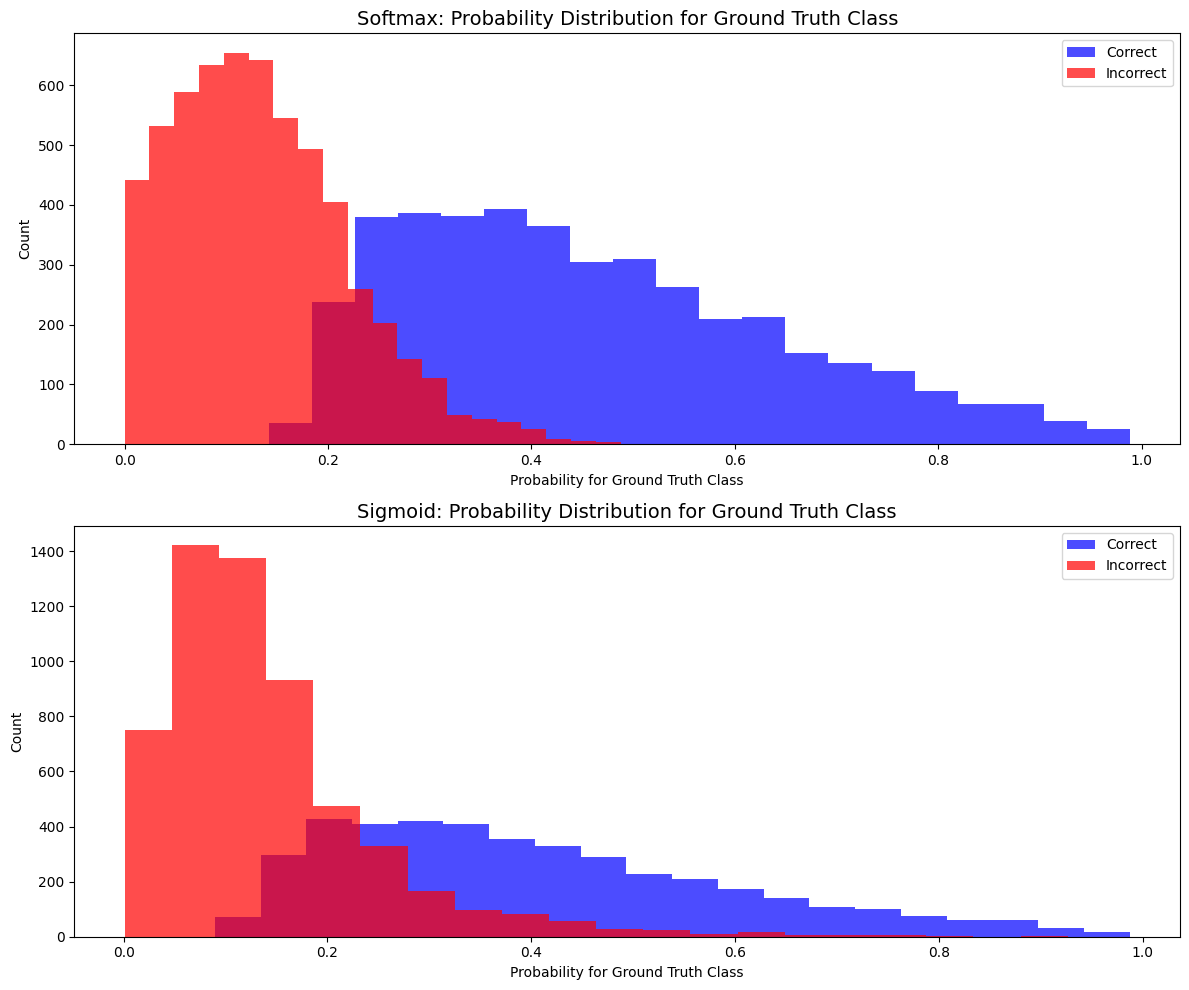

In [ ]:
# For softmax model
P_softmax = model_soft.forward(X_test)  # (K,n)
guess_softmax = np.argmax(P_softmax, axis=0)
correct_mask_soft = guess_softmax == y_test

# Manually extract the probability for each true class
prob_true_class_soft = np.zeros(len(y_test))
for i in range(len(y_test)):
    prob_true_class_soft[i] = P_softmax[int(y_test[i]), i]

# For sigmoid model
P_sigm = model_sigm.forward(X_test)  # (K,n)
guess_sigm = np.argmax(P_sigm, axis=0)
correct_mask_sigm = guess_sigm == y_test

# Manually extract the probability for each true class
prob_true_class_sigm = np.zeros(len(y_test))
for i in range(len(y_test)):
    prob_true_class_sigm[i] = P_sigm[int(y_test[i]), i]

# Now plot the histograms
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Top plot - Softmax
axes[0].hist(prob_true_class_soft[correct_mask_soft], bins=20, alpha=0.7, color='blue', label='Correct')
axes[0].hist(prob_true_class_soft[~correct_mask_soft], bins=20, alpha=0.7, color='red', label='Incorrect')
axes[0].set_title('Softmax: Probability Distribution for Ground Truth Class', fontsize=14)
axes[0].set_xlabel('Probability for Ground Truth Class')
axes[0].set_ylabel('Count')
axes[0].legend()

# Bottom plot - Sigmoid
axes[1].hist(prob_true_class_sigm[correct_mask_sigm], bins=20, alpha=0.7, color='blue', label='Correct')
axes[1].hist(prob_true_class_sigm[~correct_mask_sigm], bins=20, alpha=0.7, color='red', label='Incorrect')
axes[1].set_title('Sigmoid: Probability Distribution for Ground Truth Class', fontsize=14)
axes[1].set_xlabel('Probability for Ground Truth Class')
axes[1].set_ylabel('Count')
axes[1].legend()

plt.tight_layout()
plt.savefig('img/prob_plots.png')
plt.show()

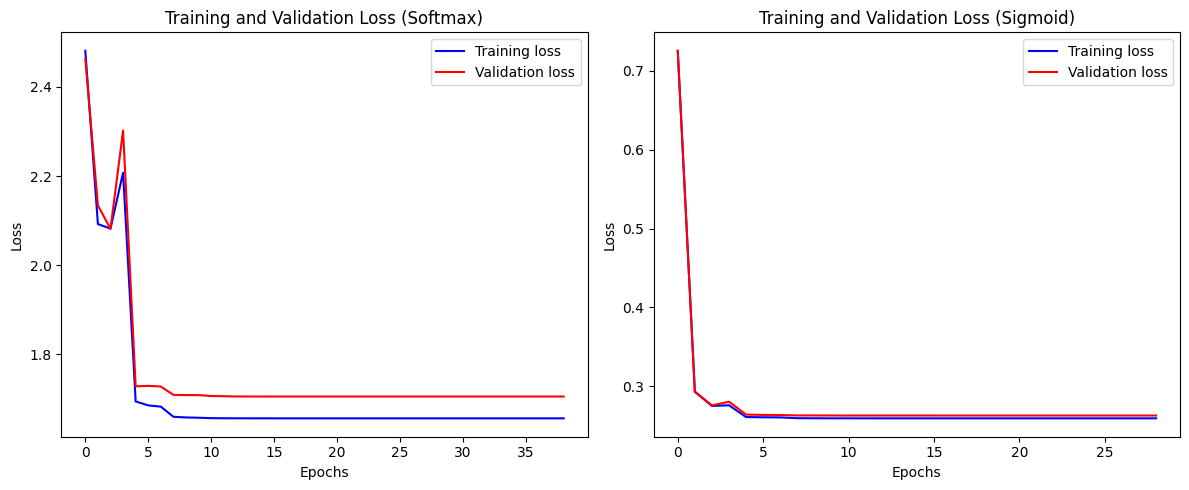

In [ ]:
# Plot training and validation losses
plt.figure(figsize=(12, 5))

# Plot for softmax model
plt.subplot(1, 2, 1)
train_loss_soft = list(soft_losses["train"].values())
val_loss_soft = list(soft_losses["val"].values())
epochs = range(len(train_loss_soft))
plt.plot(epochs, train_loss_soft, 'b-', label='Training loss')
plt.plot(epochs, val_loss_soft, 'r-', label='Validation loss')
plt.title('Training and Validation Loss (Softmax)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot for sigmoid model
plt.subplot(1, 2, 2)
train_loss_sigm = list(sigm_losses["train"].values())
val_loss_sigm = list(sigm_losses["val"].values())
epochs = range(len(train_loss_sigm))
plt.plot(epochs, train_loss_sigm, 'b-', label='Training loss')
plt.plot(epochs, val_loss_sigm, 'r-', label='Validation loss')
plt.title('Training and Validation Loss (Sigmoid)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('img/loss_plots.png')
plt.show()